In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

# 데이터

In [2]:
# 사용안하는듯
#label = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/fixed_labels_v2.csv")
#label

In [3]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')

type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [4]:
#files = {'filepath': type1_files + type2_files + type3_files,
#          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}
#
#files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
#files_df

In [5]:
#bad_files = []
#for path in tqdm(files_df['filepath'].values):
#    try:
#        img = Image.open(path)
#    except:
#        index = files_df[files_df['filepath']==path].index.values[0]
#        bad_files.append(index)

In [6]:
#bad_files
#files_df.drop(bad_files, inplace=True)

In [7]:
# save csv (files_df)
#files_df.to_csv('/kaggle/working/dropfiles.csv', sep=',')

In [8]:
# 정리된 files_df 사용
files_df = pd.read_csv('../input/cervical-dropfiles/dropfiles.csv', sep=',').drop('Unnamed: 0', axis=1)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8207,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8208,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8209,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [9]:
# get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type 2,4346
Type 3,2426
Type 1,1440


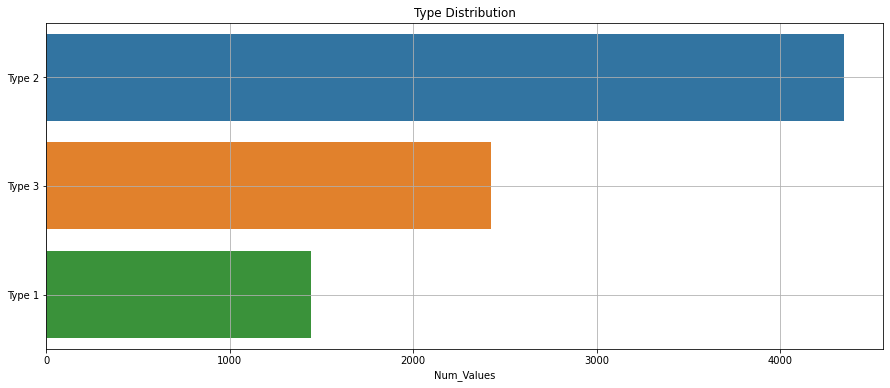

In [10]:
plt.figure(figsize = (15, 6))
sns.barplot(x= type_count['Num_Values'], y= type_count.index.to_list())
plt.title('Type Distribution')
plt.grid(True)
plt.show()

In [11]:
#pie chart

#pie_plot = go.Pie(labels= type_count.index.to_list(), values= type_count.values.flatten(),
#                 hole= 0.2, text= type_count.index.to_list(), textposition='auto')
#fig = go.Figure([pie_plot])
#fig.update_layout(title_text='Pie Chart of Type Distribution')
#fig.show()

# 데이터 분리

In [12]:
# Train / Validation

train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)

print(len(train_df), len(valid_df))

6569 1643


In [13]:
X_train = train_df[['filepath']]
y_train = train_df[['label']]
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [14]:
X_valid = valid_df[['filepath']].reset_index(drop=True)
y_valid = valid_df[['label']].reset_index(drop=True)

print(len(X_train), len(y_train), len(X_valid),len(y_valid))

6569 6569 1643 1643


# 데이터 전처리

In [15]:
# check original image size

(cv2.imread(train_df['filepath'].values[0])).shape

(4160, 3120, 3)

Text(0.5, 1.0, 'Resizing')

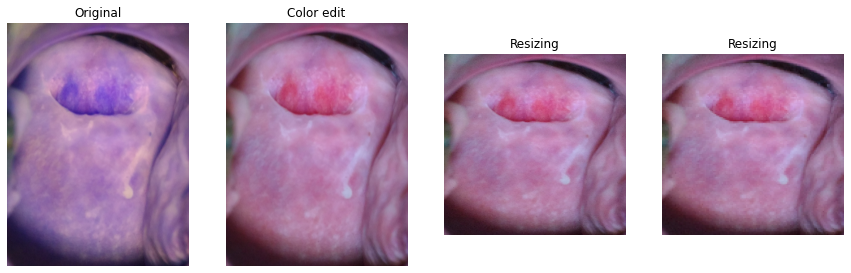

In [16]:
# load image

fig = plt.figure(figsize= (15,6))
fig.add_subplot(1,4,1)
plt.imshow(cv2.imread(train_df['filepath'].values[0]))
plt.axis(False)
plt.title('Original')

fig.add_subplot(1,4,2)
plt.imshow(cv2.cvtColor(cv2.imread(train_df['filepath'].values[0]),cv2.COLOR_RGB2BGR))
plt.axis(False)
plt.title('Color edit')

fig.add_subplot(1,4,3)
plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(train_df['filepath'].values[0]),cv2.COLOR_RGB2BGR),(224,224)))
plt.axis(False)
plt.title('Resizing')

fig.add_subplot(1,4,4)
plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(train_df['filepath'].values[0]),cv2.COLOR_RGB2BGR),(128,128)))
plt.axis(False)
plt.title('Resizing')

In [17]:
# train data

#features = []
#f_app = features.append
#path = train_df['filepath'].values
#labels = train_df['label'].values
#for p in tqdm(path):
#    image = cv2.imread(p)
#    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#    re_image = cv2.resize(image, (224,224))
#    f_app(np.array(re_image))

#X_train = np.array(features)
#y_train = np.array(labels)

In [18]:
# save train data as npy files

#np.save('/kaggle/working/X_train_224', X_train)
#np.save('/kaggle/working/y_train_224', y_train)

In [19]:
# use npy files

X_train = np.load('../input/data128/X_train_128.npy')
y_train = np.load('../input/data128/y_train_128.npy', allow_pickle=True)

In [20]:
# 소요시간줄이는코드 (추가 수정 필요)
#path = train_df['filepath'].values
#labels = train_df['label'].values
#features = [np.array(cv2.resize(cv2.cvtColor(cv2.imread(p),cv2.COLOR_RGB2BGR),(180,180))) for p in tqdm(path)]

In [21]:
# validation data

#features = []
#f_app = features.append
#path = valid_df['filepath'].values
#labels = valid_df['label'].values
#for p in tqdm(path):
#    image = cv2.imread(p)
#    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#    re_image = cv2.resize(image, (224,224))
#    f_app(np.array(re_image))

#X_valid = np.array(features)
#y_valid = np.array(labels)

In [22]:
# save validation data as npy files

#np.save('/kaggle/working/X_valid_224', X_valid)
#np.save('/kaggle/working/y_valid_224', y_valid)

In [23]:
# use npy files

X_valid = np.load('../input/data128/X_valid_128.npy', allow_pickle=True)
y_valid = np.load('../input/data128/y_valid_128.npy', allow_pickle=True)

In [24]:
# X train data 확인
X_train[0]

array([[[ 71,  81,  90],
        [ 79,  89,  97],
        [ 88, 101, 106],
        ...,
        [ 87,  57,  81],
        [ 90,  58,  82],
        [ 87,  55,  78]],

       [[ 82,  89,  97],
        [ 88,  95, 101],
        [ 96, 107, 111],
        ...,
        [100,  66,  93],
        [ 99,  65,  92],
        [ 93,  60,  88]],

       [[ 79,  83,  94],
        [ 93,  98, 104],
        [107, 114, 120],
        ...,
        [102,  67, 100],
        [ 99,  64,  96],
        [ 98,  63,  93]],

       ...,

       [[ 94,  62,  86],
        [ 75,  47,  69],
        [ 64,  43,  58],
        ...,
        [ 70,  37,  44],
        [ 69,  37,  48],
        [ 67,  36,  51]],

       [[110,  74, 100],
        [ 89,  57,  81],
        [ 77,  49,  71],
        ...,
        [ 53,  24,  28],
        [ 60,  30,  40],
        [ 65,  36,  54]],

       [[120,  84, 110],
        [108,  75,  99],
        [ 95,  63,  87],
        ...,
        [ 51,  23,  35],
        [ 60,  29,  47],
        [ 78,  46,  72]]

In [25]:
# X validation data 확인
X_valid[0]

array([[[ 59,  51,  72],
        [ 57,  49,  67],
        [ 59,  52,  70],
        ...,
        [ 29,  39,  50],
        [ 22,  31,  39],
        [ 28,  36,  45]],

       [[ 61,  53,  72],
        [ 67,  56,  76],
        [ 68,  54,  77],
        ...,
        [ 22,  40,  48],
        [ 25,  39,  48],
        [ 26,  35,  45]],

       [[ 70,  61,  80],
        [ 67,  59,  73],
        [ 71,  59,  79],
        ...,
        [ 25,  38,  54],
        [ 27,  39,  51],
        [ 28,  37,  47]],

       ...,

       [[ 95,  87, 110],
        [101,  93, 117],
        [115, 103, 127],
        ...,
        [ 63,  49,  74],
        [ 60,  47,  67],
        [ 59,  45,  69]],

       [[ 70,  67,  88],
        [ 85,  78, 101],
        [100,  91, 118],
        ...,
        [ 54,  41,  61],
        [ 54,  41,  58],
        [ 55,  42,  60]],

       [[ 50,  48,  68],
        [ 63,  60,  81],
        [ 76,  67,  93],
        ...,
        [ 53,  40,  63],
        [ 52,  39,  59],
        [ 46,  34,  50]]

In [26]:
# 정규화 (0과1사이의값)
X_train = X_train/255
X_valid = X_valid/255

In [27]:
# 정규화한 X train data 확인
X_train[0]

array([[[0.27843137, 0.31764706, 0.35294118],
        [0.30980392, 0.34901961, 0.38039216],
        [0.34509804, 0.39607843, 0.41568627],
        ...,
        [0.34117647, 0.22352941, 0.31764706],
        [0.35294118, 0.22745098, 0.32156863],
        [0.34117647, 0.21568627, 0.30588235]],

       [[0.32156863, 0.34901961, 0.38039216],
        [0.34509804, 0.37254902, 0.39607843],
        [0.37647059, 0.41960784, 0.43529412],
        ...,
        [0.39215686, 0.25882353, 0.36470588],
        [0.38823529, 0.25490196, 0.36078431],
        [0.36470588, 0.23529412, 0.34509804]],

       [[0.30980392, 0.3254902 , 0.36862745],
        [0.36470588, 0.38431373, 0.40784314],
        [0.41960784, 0.44705882, 0.47058824],
        ...,
        [0.4       , 0.2627451 , 0.39215686],
        [0.38823529, 0.25098039, 0.37647059],
        [0.38431373, 0.24705882, 0.36470588]],

       ...,

       [[0.36862745, 0.24313725, 0.3372549 ],
        [0.29411765, 0.18431373, 0.27058824],
        [0.25098039, 0

In [28]:
# 정규화한 X validation data 확인
X_valid[0]

array([[[0.23137255, 0.2       , 0.28235294],
        [0.22352941, 0.19215686, 0.2627451 ],
        [0.23137255, 0.20392157, 0.2745098 ],
        ...,
        [0.11372549, 0.15294118, 0.19607843],
        [0.08627451, 0.12156863, 0.15294118],
        [0.10980392, 0.14117647, 0.17647059]],

       [[0.23921569, 0.20784314, 0.28235294],
        [0.2627451 , 0.21960784, 0.29803922],
        [0.26666667, 0.21176471, 0.30196078],
        ...,
        [0.08627451, 0.15686275, 0.18823529],
        [0.09803922, 0.15294118, 0.18823529],
        [0.10196078, 0.1372549 , 0.17647059]],

       [[0.2745098 , 0.23921569, 0.31372549],
        [0.2627451 , 0.23137255, 0.28627451],
        [0.27843137, 0.23137255, 0.30980392],
        ...,
        [0.09803922, 0.14901961, 0.21176471],
        [0.10588235, 0.15294118, 0.2       ],
        [0.10980392, 0.14509804, 0.18431373]],

       ...,

       [[0.37254902, 0.34117647, 0.43137255],
        [0.39607843, 0.36470588, 0.45882353],
        [0.45098039, 0

In [29]:
# train 개수, 차원 확인
print(len(X_train), len(y_train))
print(X_train.shape)

6569 6569
(6569, 128, 128, 3)


In [30]:
# validation 개수, 차원 확인
print(len(X_valid), len(y_valid))
print(X_valid.shape)

1643 1643
(1643, 128, 128, 3)


In [31]:
# y 라벨링 (string -> int)
le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

In [32]:
y_train_onehot[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [33]:
y_valid_onehot[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

# 모델링

In [34]:
BATCH_SIZE = 16
EPOCHS = 100

In [35]:
# define training steps
TRAIN_STEPS = len(train_df)//BATCH_SIZE
VAL_STEPS = len(valid_df)//BATCH_SIZE

## VGG16 - pretrained
(Very Deep Convolutional Networks for Large-Scale Image Recognition(VGG-16))

https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [36]:
# Build base model
base = VGG16(input_shape = (128, 128, 3)
                   , weights = 'imagenet'
                   , include_top = False)

2022-11-22 05:33:38.635353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 05:33:38.784689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 05:33:38.785706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 05:33:38.787762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [37]:
# show trainable layers before freezing
print('This is the number of trainable weights '
'before freezing layers in the conv base:', len(base.trainable_weights))

This is the number of trainable weights before freezing layers in the conv base: 26


In [38]:
# do not train all layers (freezing few layers of pretrained model)
for layer in base.layers[:-3]:
    layer.trainable = False

In [39]:
# show trainable layers after freezing
print('This is the number of trainable weights '
'after freezing layers in the conv base:', len(base.trainable_weights))

This is the number of trainable weights after freezing layers in the conv base: 4


In [40]:
# Flatten the output layer to 1 dimension
vgg16 = Sequential([
                    base
                    , Flatten()
                    , Dense(256, activation = 'relu')
                    , Dropout(0.5)
                    , Dense(3, activation = 'softmax')
])

vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 6,817,795
Non-trainable params: 9,995,072
_________________________________________________________________


In [41]:
vgg16.compile(
    optimizer = Adam(0.0001)
    , loss = 'sparse_categorical_crossentropy'
    , metrics = ['accuracy']
)

In [42]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('vgg16.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [43]:
# train model

# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

history_vgg16 = vgg16.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen
    , epochs = 100
    , callbacks = [reduceLR, early_stopping, checkpoint]
)

2022-11-22 05:33:43.888597: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-22 05:33:45.387957: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


410/410 [==============================] - 18s 24ms/step - loss: 0.9866 - accuracy: 0.5178 - val_loss: 0.9153 - val_accuracy: 0.5606

Epoch 00001: val_accuracy improved from -inf to 0.56056, saving model to vgg16.weights.hdf5
Epoch 2/100
410/410 [==============================] - 9s 21ms/step - loss: 0.8945 - accuracy: 0.5687 - val_loss: 0.8620 - val_accuracy: 0.5977

Epoch 00002: val_accuracy improved from 0.56056 to 0.59769, saving model to vgg16.weights.hdf5
Epoch 3/100
410/410 [==============================] - 9s 21ms/step - loss: 0.7919 - accuracy: 0.6283 - val_loss: 0.8105 - val_accuracy: 0.6348

Epoch 00003: val_accuracy improved from 0.59769 to 0.63481, saving model to vgg16.weights.hdf5
Epoch 4/100
410/410 [==============================] - 9s 21ms/step - loss: 0.6644 - accuracy: 0.7015 - val_loss: 0.7802 - val_accuracy: 0.6573

Epoch 00004: val_accuracy improved from 0.63481 to 0.65733, saving model to vgg16.weights.hdf5
Epoch 5/100
410/410 [==============================] -

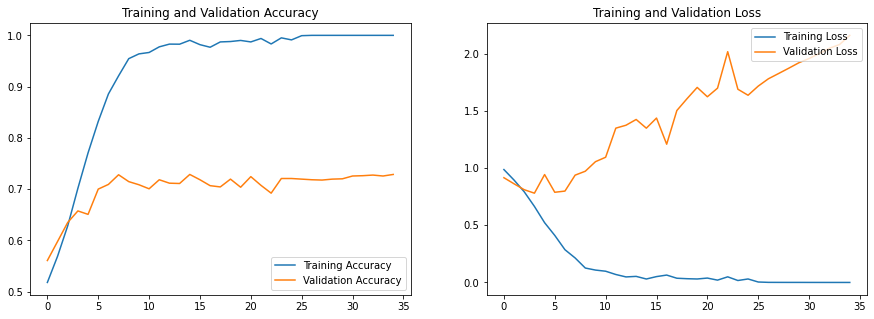

In [44]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## VGG16 (aug)

In [45]:
# augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen_ag = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)

In [46]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('vgg_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [47]:
history_vgg_ag = vgg16.fit(
    train_gen_ag
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=valid_gen
    , validation_steps=VAL_STEPS
    , epochs= 100
    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
)

Epoch 1/100
410/410 [==============================] - 31s 76ms/step - loss: 1.0091 - accuracy: 0.5472 - val_loss: 0.7100 - val_accuracy: 0.6912

Epoch 00001: val_accuracy improved from -inf to 0.69118, saving model to vgg_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 31s 74ms/step - loss: 0.9073 - accuracy: 0.5781 - val_loss: 0.7027 - val_accuracy: 0.7004

Epoch 00002: val_accuracy improved from 0.69118 to 0.70037, saving model to vgg_ag.weights.hdf5
Epoch 3/100
410/410 [==============================] - 31s 75ms/step - loss: 0.8889 - accuracy: 0.5855 - val_loss: 0.6981 - val_accuracy: 0.6973

Epoch 00003: val_accuracy did not improve from 0.70037
Epoch 4/100
410/410 [==============================] - 31s 75ms/step - loss: 0.8701 - accuracy: 0.5965 - val_loss: 0.6894 - val_accuracy: 0.7040

Epoch 00004: val_accuracy improved from 0.70037 to 0.70404, saving model to vgg_ag.weights.hdf5
Epoch 5/100
410/410 [==============================] - 31s 76ms/step - loss:

## Compare VGG16 ( non VS aug )

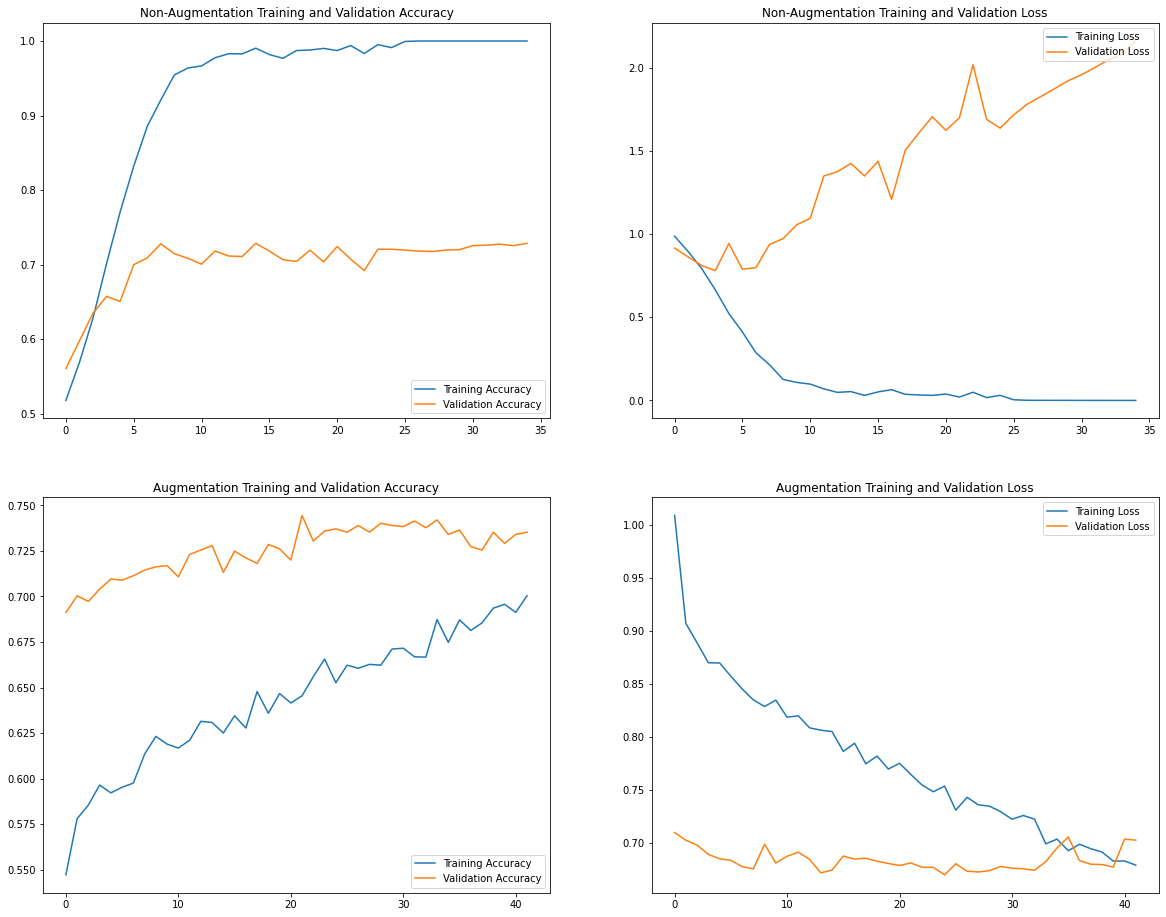

In [48]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_vgg_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_vgg_ag.history['loss'], label='Training Loss')
plt.plot(history_vgg_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## VGG16 (224) -> failed (ram)

In [49]:
# Build base model
#base_224 = VGG16(input_shape = (224, 224, 3)
#                   , weights = 'imagenet')

In [50]:
# show trainable layers before freezing
#print('This is the number of trainable weights '
#'before freezing layers in the conv base:', len(base_224.trainable_weights))

In [51]:
# do not train all layers (freezing few layers of pretrained model)
#for layer in base_224.layers[:-3]:
#    layer.trainable = False

In [52]:
# show trainable layers after freezing
#print('This is the number of trainable weights '
#'after freezing layers in the conv base:', len(base_224.trainable_weights))

In [53]:
# Flatten the output layer to 1 dimension
#vgg16_224 = Sequential([
#                    base_224
#                    , Flatten()
#                    , Dense(256, activation = 'relu')
#                    , Dropout(0.5)
#                    , Dense(3, activation = 'softmax')
#])
#
#vgg16_224.summary()

In [54]:
#vgg16_224.compile(
#    optimizer = Adam(0.0001)
#    , loss = 'sparse_categorical_crossentropy'
#    , metrics = ['accuracy']
#)

In [55]:
# define training steps
#BATCH_SIZE = 16
#TRAIN_STEPS = len(train_df)//BATCH_SIZE
#VAL_STEPS = len(valid_df)//BATCH_SIZE

In [56]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint = ModelCheckpoint('vgg16_224.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [57]:
# 터짐
# train model

# Non-augmentation
#train_gen = ImageDataGenerator().flow(X_train, y_train, batch_size = BATCH_SIZE)
#valid_gen = ImageDataGenerator().flow(X_valid, y_valid, batch_size = BATCH_SIZE)

#history_vgg16_224 = vgg16_224.fit(
#    train_gen
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs = 100
#    , callbacks = [reduceLR, early_stopping, checkpoint]
#)

In [58]:
#plt.figure(figsize=(15, 5))

#plt.subplot(1, 2, 1)
#plt.plot(history_vgg16_224.history['accuracy'], label='Training Accuracy')
#plt.plot(history_vgg16_224.history['val_accuracy'], label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

#plt.subplot(1, 2, 2)
#plt.plot(history_vgg16_224.history['loss'], label='Training Loss')
#plt.plot(history_vgg16_224.history['val_loss'], label='Validation Loss')
#plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')

#plt.show()

## Resnet50

In [59]:
resnet50 = Sequential([
    ResNet50(input_shape = (128,128,3) ,include_top = False, pooling = 'avg')
    , Flatten()
    , BatchNormalization()
    , Dense(512, activation = 'relu')
    , BatchNormalization()
    , Dense(256, activation = 'relu')
    , BatchNormalization()
    , Dense(3, activation = 'softmax')
])
resnet50.layers[0].trainable = False

resnet50.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_______________________________________________________

In [60]:
resnet50.compile(
    optimizer = 'adam'
    , loss = 'categorical_crossentropy'
    , metrics = ['accuracy']
)

In [61]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose= 1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('resnet50.weights.hdf5', monitor='val_accuracy', verbose= 1,save_best_only=True, mode= 'max')

In [62]:
# Non-augmentation
train_gen = ImageDataGenerator().flow(X_train, y_train_onehot , batch_size = BATCH_SIZE)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)

history_resnet50 = resnet50.fit(
    train_gen
    , steps_per_epoch = TRAIN_STEPS
    , validation_data = valid_gen
    , epochs = 100
    , callbacks = [reduceLR, early_stopping, checkpoint]
)

Epoch 1/100
410/410 [==============================] - 16s 31ms/step - loss: 1.1093 - accuracy: 0.4891 - val_loss: 1.0238 - val_accuracy: 0.4437

Epoch 00001: val_accuracy improved from -inf to 0.44370, saving model to resnet50.weights.hdf5
Epoch 2/100
410/410 [==============================] - 12s 29ms/step - loss: 0.9679 - accuracy: 0.5341 - val_loss: 1.0072 - val_accuracy: 0.5143

Epoch 00002: val_accuracy improved from 0.44370 to 0.51430, saving model to resnet50.weights.hdf5
Epoch 3/100
410/410 [==============================] - 12s 28ms/step - loss: 0.9468 - accuracy: 0.5498 - val_loss: 1.0104 - val_accuracy: 0.5374

Epoch 00003: val_accuracy improved from 0.51430 to 0.53743, saving model to resnet50.weights.hdf5
Epoch 4/100
410/410 [==============================] - 12s 29ms/step - loss: 0.9302 - accuracy: 0.5587 - val_loss: 0.9776 - val_accuracy: 0.5313

Epoch 00004: val_accuracy did not improve from 0.53743
Epoch 5/100
410/410 [==============================] - 11s 27ms/step -

## Resnet50 (Aug)

In [63]:
# initialize callbacks
checkpoint_ag = ModelCheckpoint('resnet_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [64]:
# augmentation
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip = True,
                                vertical_flip = True)

train_gen_ag = train_datagen.flow(X_train, y_train_onehot, batch_size= BATCH_SIZE)

history_resnet50_ag = resnet50.fit(
    train_gen_ag
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=valid_gen
    , validation_steps=VAL_STEPS
    , epochs= 100
    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
)

Epoch 1/100
410/410 [==============================] - 35s 86ms/step - loss: 2.0040 - accuracy: 0.4490 - val_loss: 1.5635 - val_accuracy: 0.5876

Epoch 00001: val_accuracy improved from -inf to 0.58762, saving model to resnet_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 35s 86ms/step - loss: 1.8205 - accuracy: 0.4628 - val_loss: 1.5089 - val_accuracy: 0.5839

Epoch 00002: val_accuracy did not improve from 0.58762
Epoch 3/100
410/410 [==============================] - 35s 84ms/step - loss: 1.7938 - accuracy: 0.4636 - val_loss: 1.4873 - val_accuracy: 0.5803

Epoch 00003: val_accuracy did not improve from 0.58762
Epoch 4/100
410/410 [==============================] - 35s 85ms/step - loss: 1.7519 - accuracy: 0.4570 - val_loss: 1.4438 - val_accuracy: 0.5815

Epoch 00004: val_accuracy did not improve from 0.58762
Epoch 5/100
410/410 [==============================] - 34s 84ms/step - loss: 1.7340 - accuracy: 0.4590 - val_loss: 1.3958 - val_accuracy: 0.5790

Epoch 000

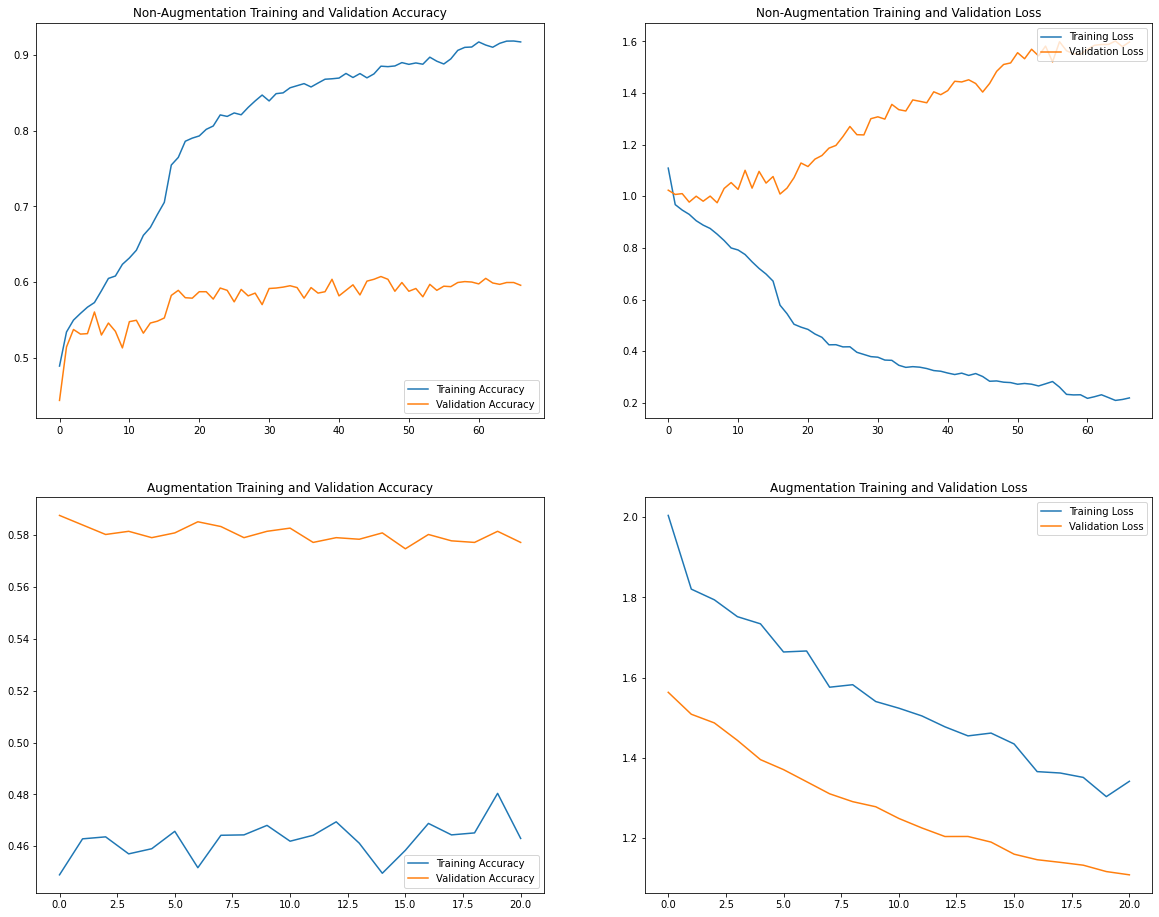

In [65]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(history_resnet50_ag.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50_ag.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(history_resnet50_ag.history['loss'], label='Training Loss')
plt.plot(history_resnet50_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()

## GoogLeNet - failed

In [66]:
#from keras.models import Model
#from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
#from keras.layers.merge import concatenate

In [67]:
# Create Inception block


#def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
#  # Input: 
#  # - f1: number of filters of the 1x1 convolutional layer in the first path
#  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
#  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
#  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

#  # 1st path:
#  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

#  # 2nd path
#  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
#  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

#  # 3rd path
#  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
#  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

#  # 4th path
#  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
#  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

#  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

#  return output_layer

sequential로 변경시도

In [68]:
#googlenet = Sequential([
#    Input(shape = (128,128,3))
#    , Conv2D(filters = 64, kernel_size =(7,7), strides = 2, padding = 'valid', activation = 'relu')
#    , MaxPooling2D(pool_size = (3,3), strides = 2)
#    , Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')
#    , Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')
#    , MaxPooling2D(pool_size= (3,3), strides = 2)
##first inception block
#    , Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)
##second inception block
#    , Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)
#    , MaxPooling2D(pool_size= (3,3), strides = 2)
##third inception block
#    , Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)
##Extra network 1   
#])

In [69]:
#def GoogLeNet():
#  # input layer 
#  input_layer = Input(shape = (128, 128, 3))

#  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
#  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

#  # max-pooling layer: pool_size = (3,3), strides = 2
#  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

#  # convolutional layer: filters = 64, strides = 1
#  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

#  # convolutional layer: filters = 192, kernel_size = (3,3)
#  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

#  # max-pooling layer: pool_size = (3,3), strides = 2
#  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

#  # 1st Inception block
#  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

#  # 2nd Inception block
#  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

#  # max-pooling layer: pool_size = (3,3), strides = 2
#  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

#  # 3rd Inception block
#  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

#  # Extra network 1:
#  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
#  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
#  X1 = Flatten()(X1)
#  X1 = Dense(1024, activation = 'relu')(X1)
#  X1 = Dropout(0.7)(X1)
#  X1 = Dense(3, activation = 'softmax')(X1)

  
#  # 4th Inception block
#  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

#  # 5th Inception block
#  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

#  # 6th Inception block
#  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

#  # Extra network 2:
#  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
#  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
#  X2 = Flatten()(X2)
#  X2 = Dense(1024, activation = 'relu')(X2)
#  X2 = Dropout(0.7)(X2)
#  X2 = Dense(3, activation = 'softmax')(X2)
#  
#  
#  # 7th Inception block
#  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
#                      f3_conv5 = 128, f4 = 128)
#
#  # max-pooling layer: pool_size = (3,3), strides = 2
#  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)
#
#  # 8th Inception block
#  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)
#
#  # 9th Inception block
#  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

#  # Global Average pooling layer 
#  X = GlobalAveragePooling2D(name = 'GAPL')(X)

#  # Dropoutlayer 
#  X = Dropout(0.4)(X)

#  # output layer 
#  X = Dense(3, activation = 'softmax')(X)
  
#  # model
#  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

#  return model

In [70]:
#googlenet = GoogLeNet()

In [71]:
#googlenet.summary()

In [72]:
#googlenet.compile(
#    optimizer='adam'
#    , loss = 'categorical_crossentropy'
#    , metrics = ['accuracy']
#)

In [73]:
# initialize callbacks
#reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

#checkpoint = ModelCheckpoint('ggl.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [74]:
# Non-augmentation
#train_gen = ImageDataGenerator().flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
#valid_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)

#history_Google = googlenet.fit(
#    train_gen
#    , steps_per_epoch = TRAIN_STEPS
#    , validation_data = valid_gen
#    , epochs = EPOCHS
#    , callbacks = [reduceLR, early_stopping, checkpoint]
#)

# 모델진단

In [75]:
test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
test_y.loc[1,['Type_1','Type_2','Type_3']]

root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
test_dir = os.path.join(root_dir,'test', 'test')

test_type = []
test_features = []
i=0
for fn in tqdm(test_y[['image_name']].to_numpy()):
    for filename in fn:
        filepath = os.path.join(test_dir,filename)
        img = cv2.imread(filepath)
        resized_img = cv2.resize(img, (128, 128))
        test_features.append(np.array(resized_img))
        test_type.append(np.array(test_y.loc[i,['Type_1','Type_2','Type_3']]))
        i=i+1
        
#np.save('/kaggle/working/X_test_128', X_valid)
#np.save('/kaggle/working/y_test_128', y_valid)

100%|██████████| 512/512 [02:00<00:00,  4.23it/s]


In [76]:
#load best weights
#vgg16.load_weights('cervicalModel.weights.hdf5')

In [77]:
#vgg16.evaluate(test_gen)

In [78]:
#이미지 오류남

#stage1 = y_train[y_train == 0].index
#stage2 = y_train[y_train == 1].index
#stage3 = y_train[y_train == 2].index

#

#stage1 = np.where(y_train == 0)
#type(stage1)
#stageq = stage1[0]

#stage2 = np.where(y_train == 1)
#type(stage2)
#stagew = stage2[0]

#stage3 = np.where(y_train == 2)
#type(stage3)
#stagee = stage3[0]

#

#plt.figure(figsize=(20, 20))

#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('Type1 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stageq[i]])
#    plt.title('Type1')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.show()

#

#plt.figure(figsize=(20, 20))

#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('type2 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stagew[i]])
#    plt.title('type2')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.savefig('type2.png', dpi=300)
#plt.show()

#

#plt.figure(figsize=(20, 20))
#
#for i in range(16):
#    plt.subplot(4, 4, i+1)
#    plt.suptitle('type3 Images', fontsize=20) # 하나의 큰 제목 설정
#    plt.imshow(X_train[stagee[i]])
#    plt.title('type3')
#    plt.subplots_adjust(hspace=0.5)
#    plt.axis(False)
#plt.savefig('type3.png', dpi=300)
#plt.show()

In [79]:
# 참고용
# double

#history_df_cnn = pd.DataFrame(historycnn.history)
#history_df_dnn = pd.DataFrame(historydnn.history)

#plt.figure(figsize= (15,6))
#plt.subplot(1,2,1)
#plt.plot(history_df_cnn['accuracy'], label= 'cnn_accuracy' )
## plt.plot(history_df_cnn['val_accuracy'], label= 'val_accuracy')
#plt.plot(history_df_dnn['accuracy'], label= 'dnn_accuracy', color='limegreen' )
## plt.plot(history_df_dnn['val_accuracy'], label= 'val_accuracy', color='limegreen')
## history_df[['acc', 'val_acc']]
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.title('Training and Validation Accuracy History')
#plt.legend()

# display history of loss
#plt.subplot(1,2,2)
#plt.plot(history_df_cnn['loss'], label= 'cnn_loss')
##plt.plot(history_df_cnn['val_loss'], label= 'val_loss')
#plt.plot(history_df_dnn['loss'], label= 'dnn_loss', color='limegreen')
##plt.plot(history_df_dnn['val_loss'], label= 'val_loss', color='limegreen')
# history_df[['loss', 'val_loss']].plot()
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss History')
#plt.legend()
#plt.savefig('fig2.png', dpi=300)
#plt.show()


In [80]:
#plt.figure(figsize= (6,6))
#plt.plot(history_df_cnn['accuracy'], label= 'cnn_accuracy' )
##plt.plot(history_df_cnn['val_loss'], label= 'val_loss')
##plt.plot(history_df_dnn['loss'], label= 'dnn_loss', color='limegreen')
##plt.plot(history_df_dnn['val_loss'], label= 'val_loss', color='limegreen')
## history_df[['loss', 'val_loss']].plot()
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training and Validation Loss History')
#plt.legend()
#plt.savefig('cnnaccuracy.png', dpi=300)
#plt.show()

# test data (2차에 활용)

In [81]:
# test data

#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

#root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
#test_dir = os.path.join(root_dir,'test', 'test')

#test_type = []
#test_features = []
#i=0
#for fn in test_y[['image_name']].to_numpy():
#    for filename in fn:
#        filepath = os.path.join(test_dir,filename)
#        #print(filepath)
#        img = cv2.imread(filepath)
#        resized_img = cv2.resize(img, (180, 180))
#        test_features.append(np.array(resized_img))
#        test_type.append(np.array(test_y.loc[i,['Type_1','Type_2','Type_3']]))
#        i=i+1
    
#print( len(test_features))

In [82]:
#test_y = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv")
#test_y.loc[1,['Type_1','Type_2','Type_3']]

In [83]:
#y_test = test_y.loc[:,['Type_1','Type_2','Type_3']]
#y_test
#import tensorflow as tf

In [84]:
#y_train_onehot

In [85]:
#print(y_test)
#list = []
#for d in y_test.index:
#    res = y_test.loc[d,:].values.tolist()
#    list.append(res)

In [86]:
#y_test = np.array(list)
#y_test

In [87]:
# normalize test features
#test_X = np.array(test_features)
#X_test = test_X/255

In [88]:
#print(cnn.evaluate(X_test, y_test))
#print(dnn.evaluate(X_test, y_test))